**Step 1: GPU Configuration**

In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


**Step 2: Mount Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Step 3: Install TensorFlow Addons and Visualkeras**

In [3]:
!pip install tensorflow_addons visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 39.2 MB/s eta 0:00:00


**Step 4: Import Required Libraries**

In [4]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import warnings
import itertools
import pandas as pd
from PIL import Image
from sklearn.utils import class_weight
from collections import Counter
import tensorflow_addons as tfa
import visualkeras
import plotly.express as px
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
%matplotlib inline


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


**Step 5: Define Data Loading Function**

In [5]:
labels = ["Insect Infestation", "Mosaic Disease"]
img_size = 64

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)

        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[..., ::-1]
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error reading or processing image {img} in {label} category: {e}")

    return data


**Step 6: Load Data**

In [6]:
data_dir = get_data("/content/drive/MyDrive/Luffa Dataset")

**Step 7: Count Images**

In [7]:
image_names = glob.glob(os.path.join('/content/drive/MyDrive/Luffa Dataset', '*', '*'))
print("Total number of training images: ", len(image_names))

image_names = pd.Series(image_names)

Total number of training images:  6226


**Step 8: Create DataFrame**

In [8]:
data_df = pd.DataFrame()
data_df['Filename'] = image_names.map(lambda img_name: img_name.split("/")[-1])
data_df['ClassId'] = image_names.map(lambda img_name: (img_name.split("/")[-2]))
data_df.head()

,Filename,ClassId
0,Insect Infestation (415).jpg,Insect Infestation
1,Insect Infestation (411).jpg,Insect Infestation
2,Insect Infestation (413).jpg,Insect Infestation
3,Insect Infestation (423).jpg,Insect Infestation
4,Insect Infestation (418).jpg,Insect Infestation


**Step 9: Sample Images**

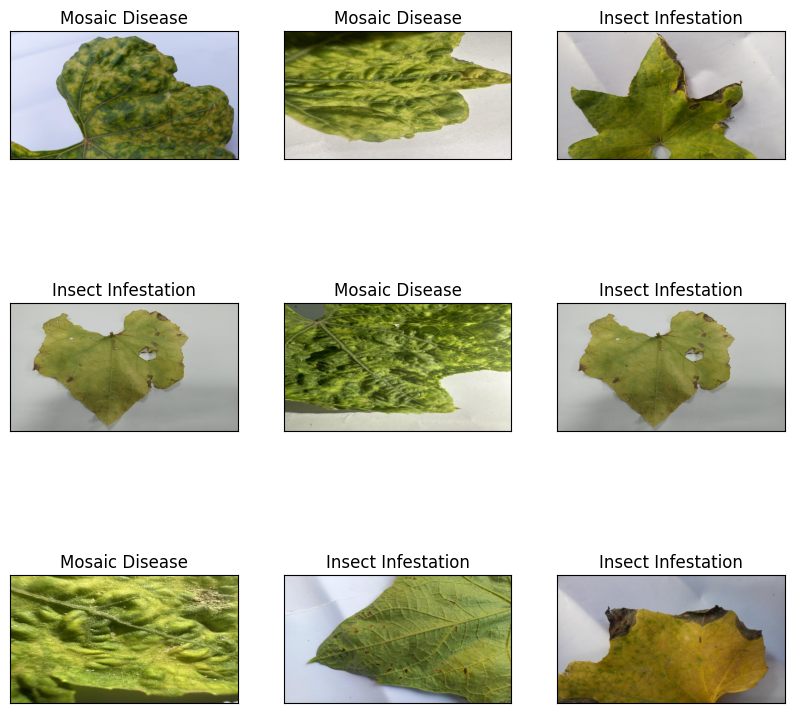

In [9]:
plot_df = data_df.sample(min(9, len(data_df))).reset_index()

plt.figure(figsize=(10, 10))

for i in range(9):
    img_name = plot_df.loc[i, 'Filename']
    label_str = (plot_df.loc[i, 'ClassId'])
    plt.subplot(3,3,i+1)
    plt.imshow(plt.imread(os.path.join('/content/drive/MyDrive/Luffa Dataset',label_str, img_name)))
    plt.title(label_str)
    plt.xticks([])
    plt.yticks([])


**Step 10: Class Distribution**

In [10]:
class_id_distribution = data_df['ClassId'].value_counts()
class_id_distribution.head(10)

ClassId
Mosaic Disease        3721
Insect Infestation    2505
Name: count, dtype: int64

**Step 11: Plot Class Distribution**

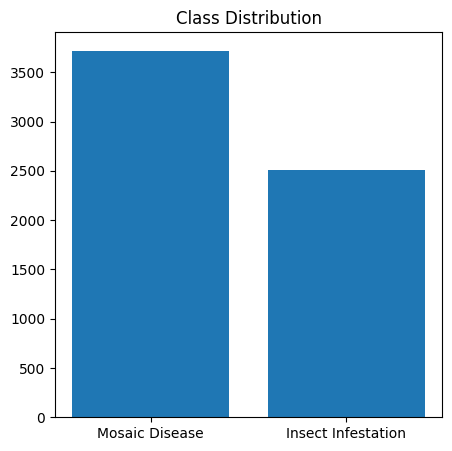

In [11]:
plt.figure(figsize=(5,5))
plt.xticks(np.arange(len(class_id_distribution)))
plt.bar(class_id_distribution.index, class_id_distribution.values)
plt.title("Class Distribution")
plt.show()

**Step 12: Display Sample Image**

Text(0.5, 1.0, 'Insect Infestation')

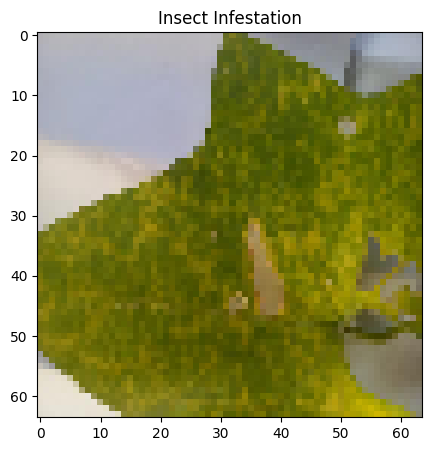

In [12]:
plt.figure(figsize = (5,5))
plt.imshow(data_dir[1][0])
plt.title(labels[data_dir[1][1]])  # Fixed index to refer to second element

**Step 13: Prepare Data**

In [13]:
X = []
Y = []

for feature, label in data_dir:
    X.append(feature)
    Y.append(label)
X = np.array(X) / 255.0
X = X.reshape(-1, img_size, img_size, 3)  # Fixed reshaping to 3 channels
Y = np.array(Y)

**Step 14: Check Shape**

In [14]:
print(X.shape)

(6226, 64, 64, 3)


**Step 15: Split Data**

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, stratify=Y, random_state=42)

**Step 16: Further Split Data**

In [16]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.18, random_state=8)

**Step 17: Check Shapes**

In [17]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (4594, 64, 64, 3) - y_train shape: (4594,)
x_val shape: (1009, 64, 64, 3) - y_val shape: (1009,)
x_test shape: (623, 64, 64, 3) - y_test shape: (623,)


**Step 18: Import Additional Libraries**

**Step 19: Set Parameters**

In [18]:
num_classes = 2
input_shape = (64, 64, 3)

**Step 20: Define Hyperparameters**

In [19]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 250
image_size = 64
patch_size = 8
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 3
transformer_units = [projection_dim * 2, projection_dim]
transformer_layers = 1
mlp_head_units = [2048, 1024]

**Step 21: Data Augmentation**

In [20]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(x_train)


**Step 22: Define MLP**

In [21]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

**Step 23: Define Patches Layer**

In [22]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

**Step 24: Visualize Patches**

Image size: 64 X 64
Patch size: 8 X 8
Patches per image: 64
Elements per patch: 192


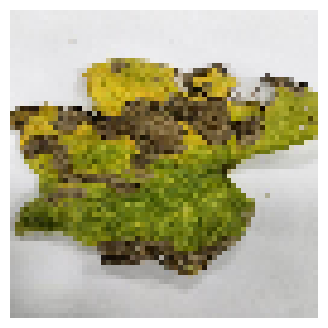

In [23]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("float"))
plt.axis("off")

resized_image = tf.image.resize(tf.convert_to_tensor([image]), size=(image_size, image_size))
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

**Step 25: Plot Patches**

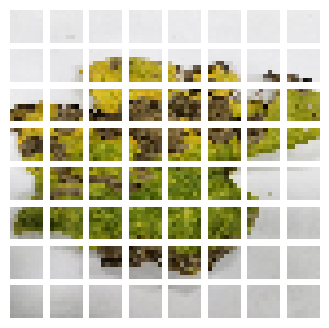

In [24]:
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("float"))
    plt.axis("off")


**Step 26: Define Patch Encoder**

In [25]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

**Step 27: Create ViT Classifier**

In [26]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    logits = layers.Dense(num_classes)(features)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


**Step 28: Compile Model with run_experiment Function**

In [27]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )
    model.summary()

    checkpoint_filepath = "/content/drive/MyDrive/model/vit_classifier.h5"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.1,
        cooldown=10,
        patience=10,
        verbose=1,
        min_lr=0.1e-7,
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        patience=15,
        verbose=1,
        mode='auto'
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_val, y_val),
        callbacks=[checkpoint_callback, lr_reducer, early_stopping],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 data_augmentation (Sequent  (None, 64, 64, 3)            7         ['input_1[0][0]']             
 ial)                                                                                             
                                                                                                  
 patches_1 (Patches)         (None, None, 192)            0         ['data_augmentation[0][0]']   
                                                                                                  
 patch_encoder (PatchEncode  (None, 64, 64)               16448     ['patches_1[0][0]']       

**Step 29: Save Model**

In [28]:
model_path = "/content/drive/MyDrive/vit_classifier.h5"
vit_classifier.save(model_path)

**Step 30: Load Model**

In [29]:
loaded_model = tf.keras.models.load_model(model_path, custom_objects={'PatchEncoder': PatchEncoder, 'Patches': Patches})

**Step 31: Visualize Training History**

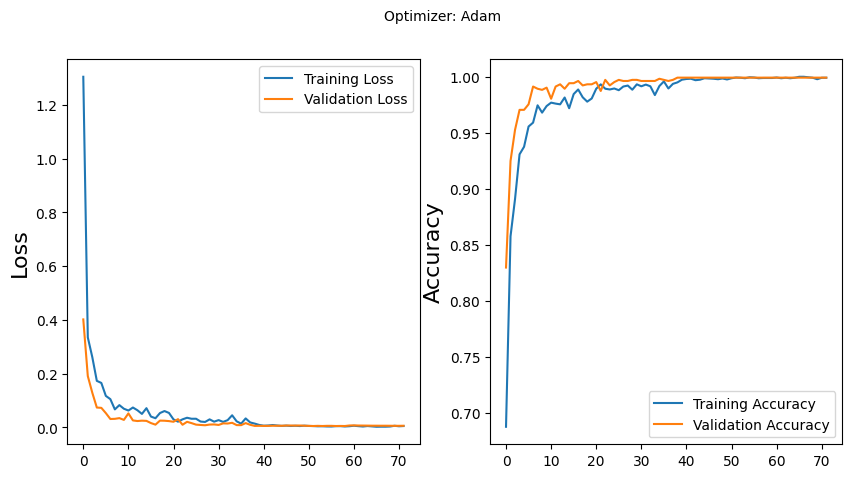

CPU times: user 434 ms, sys: 117 ms, total: 552 ms
Wall time: 442 ms


In [30]:
%%time
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer: Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


**Step 32: Predict on Validation Set**

In [31]:
%%time
vit_predictions_val = vit_classifier.predict(x_val)
vit_y_pred_val = [np.argmax(probas) for probas in vit_predictions_val]


32/32 [==============================] - 2s 47ms/step
CPU times: user 2.95 s, sys: 166 ms, total: 3.12 s
Wall time: 3.1 s


**Step 33: Plot Confusion Matrix Function**

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f%' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


**Step 34: Compute and Plot Confusion Matrix for Validation Set**

Confusion matrix, without normalization
[[412   0]
 [  1 596]]


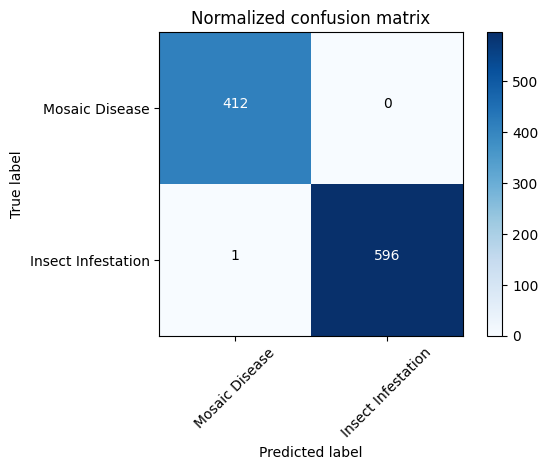

CPU times: user 271 ms, sys: 134 ms, total: 405 ms
Wall time: 279 ms


In [33]:
%%time
cnf_matrix_val = confusion_matrix(y_val, vit_y_pred_val)
np.set_printoptions(precision=2)
# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_val, classes=["Mosaic Disease", "Insect Infestation"], title='Normalized confusion matrix')
plt.show()

**Step 35: Print Classification Report for Validation Set**

In [34]:
%%time
print(classification_report(y_val, vit_y_pred_val, target_names=["Mosaic Disease", "Insect Infestation"]))


                    precision    recall  f1-score   support

    Mosaic Disease       1.00      1.00      1.00       412
Insect Infestation       1.00      1.00      1.00       597

          accuracy                           1.00      1009
         macro avg       1.00      1.00      1.00      1009
      weighted avg       1.00      1.00      1.00      1009

CPU times: user 10.4 ms, sys: 39 µs, total: 10.4 ms
Wall time: 10.2 ms


**Step 36: Predict on Test Set**

In [35]:
%%time
vit_predictions_test = vit_classifier.predict(x_test)
vit_y_pred_test = [np.argmax(probas) for probas in vit_predictions_test]

20/20 [==============================] - 1s 48ms/step
CPU times: user 1.65 s, sys: 82.6 ms, total: 1.73 s
Wall time: 1.11 s


**Step 37: Compute and Plot Confusion Matrix for Test Set**

Confusion matrix, without normalization
[[248   3]
 [  0 372]]


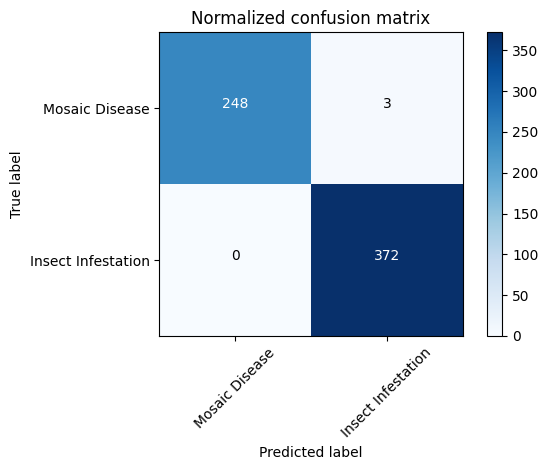

CPU times: user 281 ms, sys: 141 ms, total: 422 ms
Wall time: 278 ms


In [36]:
%%time
cnf_matrix_test = confusion_matrix(y_test, vit_y_pred_test)
np.set_printoptions(precision=2)
# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_test, classes=["Mosaic Disease", "Insect Infestation"], title='Normalized confusion matrix')
plt.show()


**Step 38: Print Classification Report for Test Set**

In [37]:
%%time
print(classification_report(y_test, vit_y_pred_test, target_names=["Mosaic Disease", "Insect Infestation"]))

                    precision    recall  f1-score   support

    Mosaic Disease       1.00      0.99      0.99       251
Insect Infestation       0.99      1.00      1.00       372

          accuracy                           1.00       623
         macro avg       1.00      0.99      0.99       623
      weighted avg       1.00      1.00      1.00       623

CPU times: user 8.36 ms, sys: 0 ns, total: 8.36 ms
Wall time: 9.06 ms


**Step 41: Visualize Model Architecture**

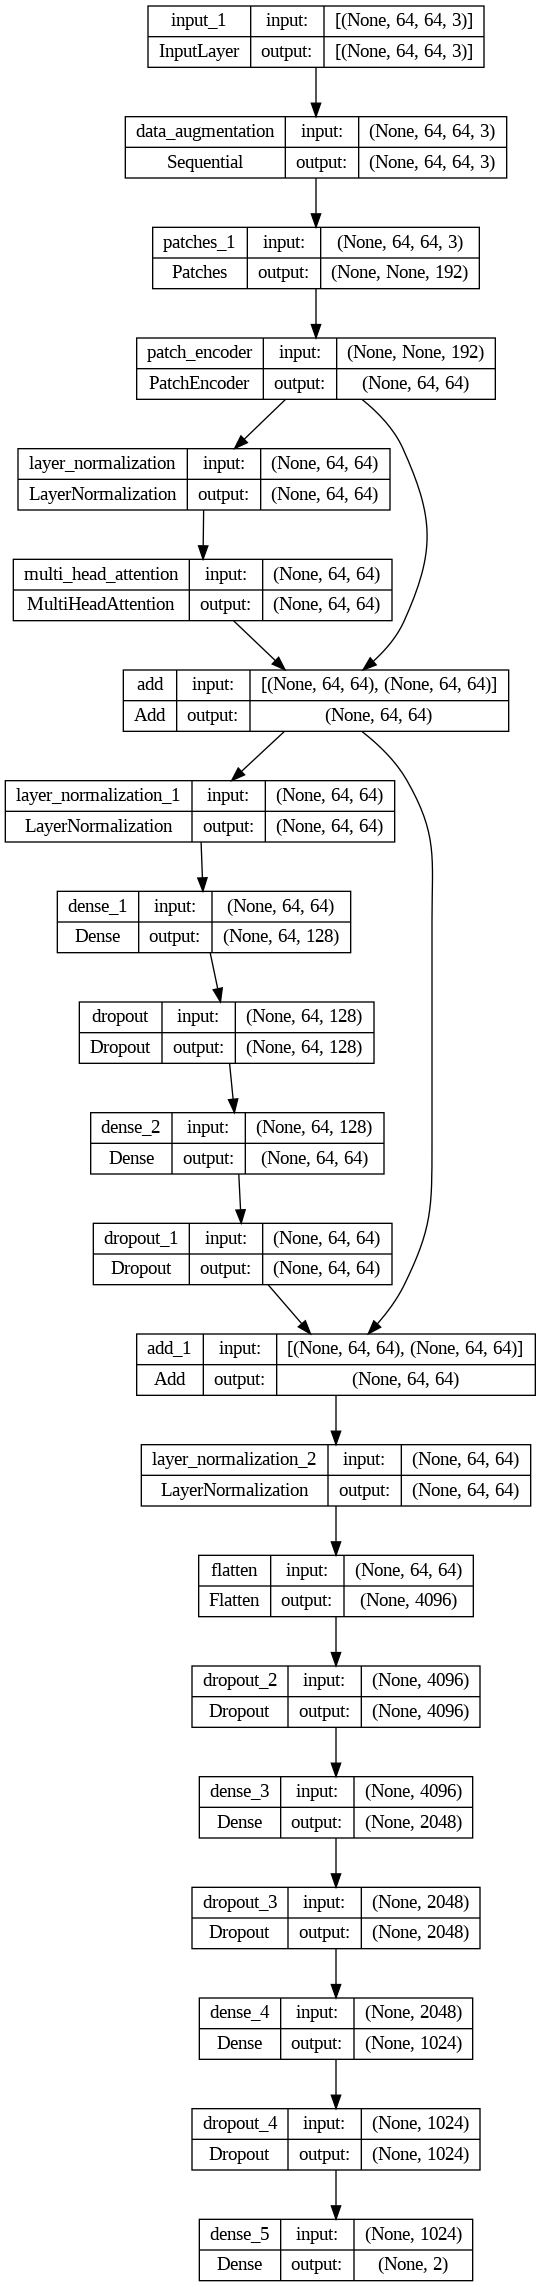

In [38]:
# Step 36: Visualize Model Architecture
plot_model(vit_classifier, to_file='/content/drive/MyDrive/vit_classifier_architecture.png', show_shapes=True)
